# Project: A Soccer Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This project looks at the **Soccer Dataset** available from [Kaggle](https://www.kaggle.com/hugomathien/soccer/data), which contains information on +10k players and +25k football matches from 11 European Countries between 2008 and 2016. Particularly, we'll be looking at the players trying to reveal interesting connections between their characteristics (birthday, height, weight) and their performance attributes. We will also calculate two derived variables to use in the analysis (age and BMI).
<br>The questions we try to answer are as follows:
- [What are the top characteristics of highly rated players?](#q1)
- [In what way does players' BMI (Body Mass Index) influence their performance?](#q2)
- [Which performance attributes improve with age, and which ones decline?](#q3)
- [Are higher players really better at heading / jumping / vision?](#q4)
- [Can zodiac sign influence a player's talents?](#q5)

We'll begin by importing the essential modules required:

In [1]:
# imports and 'magics'
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section we'll load the data, formulate cleaning requirements and plan which features to use.

### General Properties
First step would be to load the dataset via sqlite and check the tables:

In [2]:
# connect to database and view tables
database = 'database.sqlite'
conn = sqlite3.connect(database)
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


From the description of the dataset on [Kaggle](https://www.kaggle.com/hugomathien/soccer/data), we know that the tables containing players information are:
<br>
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Player* - general player information, and
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Player_Attributes* - a collection of attributes maintained by [sofifa.com](http://sofifa.com/).
(FIFA series and all FIFA assets property of EA Sports.)
<br>
<br>We will be using these two sets, so we can save them as pandas dataframe objects. Once created, we'll briefly glance at the structure of each one to better understand its contents.

In [3]:
# loading the tables as pandas dataframes
p_df = pd.read_sql("""SELECT * FROM Player;""", conn)
a_df = pd.read_sql("""SELECT * FROM Player_Attributes;""", conn)

In [4]:
# getting a general idea of the contents of the players table
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 604.9+ KB


In [5]:
# printing the first 3 entries in the players table
p_df.head(3)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163


It seems there are **11060** unique players in the dataset. We can further confirm they are unique this by looking at the *id* columns.

In [6]:
# checking that the number of unique observations of each id is equal to the number of rows
p_df.id.nunique() == p_df.player_api_id.nunique() == p_df.player_fifa_api_id.nunique() == p_df.shape[0]

True

In [7]:
# getting a general view of the player attributes table
a_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

In [8]:
# printing the first 3 entries, transposed for a better view.
a_df.head(3).T

,0,1,2
id,1,2,3
player_fifa_api_id,218353,218353,218353
player_api_id,505942,505942,505942
date,2016-02-18 00:00:00,2015-11-19 00:00:00,2015-09-21 00:00:00
overall_rating,67,67,62
potential,71,71,66
preferred_foot,right,right,right
attacking_work_rate,medium,medium,medium
defensive_work_rate,medium,medium,medium
crossing,49,49,49


The *a_df* dataframe has many more entries, and it seems to contain several observations of each player taken at different times. To confirm this is the case, we look at the ids again:

In [9]:
# grouping by 'player_api_id' shows that for each player there are more observations taken at different dates
a_df.groupby('player_api_id').nunique().head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,14,1,1,14,5,4,1,2,1,3,...,2,3,3,2,4,2,2,2,3,3
2752,21,1,1,21,7,5,1,1,1,3,...,3,3,5,4,4,2,2,2,2,2
2768,21,1,1,21,9,7,1,1,1,4,...,3,5,7,6,6,3,3,3,3,3
2770,15,1,1,15,6,8,2,1,1,5,...,4,4,3,4,1,2,2,4,2,2
2790,5,1,1,5,5,3,1,1,1,5,...,1,4,5,4,1,1,3,4,3,2


In [10]:
# selecting just one player id as an example
a_df[a_df.player_api_id == 2625]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
139843,139844,148544,2625,2015-01-16 00:00:00,61.0,61.0,right,medium,medium,50.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
139844,139845,148544,2625,2014-11-07 00:00:00,61.0,61.0,right,medium,medium,50.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
139845,139846,148544,2625,2014-09-18 00:00:00,61.0,61.0,right,medium,medium,50.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
139846,139847,148544,2625,2013-06-07 00:00:00,61.0,61.0,right,medium,medium,50.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
139847,139848,148544,2625,2013-03-08 00:00:00,61.0,61.0,right,medium,medium,50.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
139848,139849,148544,2625,2013-02-15 00:00:00,58.0,58.0,right,medium,medium,52.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139849,139850,148544,2625,2012-08-31 00:00:00,58.0,58.0,right,medium,medium,52.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139850,139851,148544,2625,2012-02-22 00:00:00,58.0,58.0,right,medium,medium,52.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139851,139852,148544,2625,2011-08-30 00:00:00,58.0,58.0,right,high,medium,52.0,...,55.0,66.0,63.0,63.0,52.0,12.0,11.0,6.0,8.0,8.0
139852,139853,148544,2625,2011-02-22 00:00:00,59.0,63.0,right,high,medium,52.0,...,55.0,66.0,63.0,63.0,62.0,12.0,11.0,6.0,8.0,8.0


This particular player has observations ranging **from 2007 to 2015** with his attributes changing over time. The different timestamps would be useful if we were to do a time series analysis, but for the scope of this project we will use just **one observation per player**.
<br>One way to obtain that would be to look at the **most recent timestamp with the most information** (for as many players and as many fields as possible). Grouping by date will show if any date would be a good candidate.

In [11]:
(a_df.groupby('date')
     .nunique()
     .player_api_id
     .sort_values(ascending=False))

date
2007-02-22 00:00:00    11059
2011-08-30 00:00:00     6520
2015-09-21 00:00:00     6518
2013-09-20 00:00:00     6513
2012-08-31 00:00:00     6491
2014-09-18 00:00:00     6429
2013-02-15 00:00:00     6373
2010-08-30 00:00:00     6366
2012-02-22 00:00:00     6134
2009-08-30 00:00:00     5691
2011-02-22 00:00:00     5448
2008-08-30 00:00:00     5387
2010-02-22 00:00:00     4457
2007-08-30 00:00:00     4343
2009-02-22 00:00:00     3299
2013-03-22 00:00:00     1945
2013-02-22 00:00:00     1487
2015-01-09 00:00:00     1480
2015-10-16 00:00:00     1469
2013-03-08 00:00:00     1292
2014-02-07 00:00:00     1244
2014-10-02 00:00:00     1217
2015-04-10 00:00:00     1188
2014-11-14 00:00:00     1187
2016-03-10 00:00:00     1180
2014-01-31 00:00:00     1064
2015-11-06 00:00:00     1060
2013-04-19 00:00:00     1048
2016-04-21 00:00:00     1044
2014-04-04 00:00:00     1036
                       ...  
2016-06-23 00:00:00       52
2014-08-22 00:00:00       52
2013-09-13 00:00:00       51
2015-01-2

There are **11059** unique players observations taken on **2007-02-22**, which is close to our 11060 unique players, but looking at just that date would ignore players evolution over time.
<br>A better alternative would to be to **average** the attributes accross all years, and get our most recent mean values. In the end we hope to end up with 11060 entries representing the means of players' attributes accross the given date range.
<br>In order to limit the analysis to just quantitative variables, we can also discard some columns which contain categorical variables (*attacking_work_rate* and *defensive_work_rate*).
<br>We will do these steps in the following section.
<br>
<br>Next, we have to decide which *key* would connect the two tables:

In [12]:
print(a_df.player_api_id.nunique()) # printing the unique values count for 'player_api_id'
print(a_df.player_fifa_api_id.nunique()) # printing the unique values count for 'player_fifa_api_id'

11060
11062


There seems to be a missmatch between the unique id fields, but since ***player_api_id*** value matches the number of unique players from the first table, we will use this key to connect the two dataframes, and will drop the other column (*player_fifa_api_id*) from both tables.

### Data Cleaning

The first dataframe (*p_df*) seems already clean, but we can still check for null values and duplicates.

In [13]:
# checking for null values in p_df columns
print(p_df.isnull().any().any())

# checking for duplicates
print(p_df.duplicated().any())

False
False


Doing the same for the second dataframe, *a_df*:

In [14]:
# checking for null values in a_df columns
print(a_df.isnull().any().any())

# checking for duplicates
print(a_df.duplicated().any())

True
False


In [15]:
# getting a closer look at the null values in 'a_df'
a_df.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

It seems the number of missing values is not material given the total number of entries in this table (183978). Since we will be averaging the values for each player on each attribute, the NaNs will be ignored in the process. There are no duplicates in any of the dataframes as we checked.
<br>
<br>Also, now would be a good time to set the **indexes** for the two dataframes.

In [16]:
# setting 'player_api_id' as index for the players table
p_df.set_index('player_api_id', inplace=True)

# setting the 'id' column as index for the attributes table
a_df.set_index('id', inplace=True)

The *birthday* column in *p_df* and the *date* column in *a_df* need to be converted to **datetime**:

In [17]:
p_df.birthday = pd.to_datetime(p_df.birthday)
a_df.date = pd.to_datetime(a_df.date)

We can also **drop** the columns which we will not use from both tables:

In [18]:
p_df.drop(['id', 'player_fifa_api_id'], axis=1, inplace=True)

In [19]:
a_df.drop(['player_fifa_api_id', 'attacking_work_rate', 'defensive_work_rate'], axis=1, inplace=True)

One particular feature of our soccer dataset is that it mixes field players with goalkeepers. This is evident if we look at the distribution of attribute values for specific columns which relate to goalkeepers (*gk_diving*, *gk_handling*, *gk_kicking*, *gk_positioning* and *gk_reflexes*):

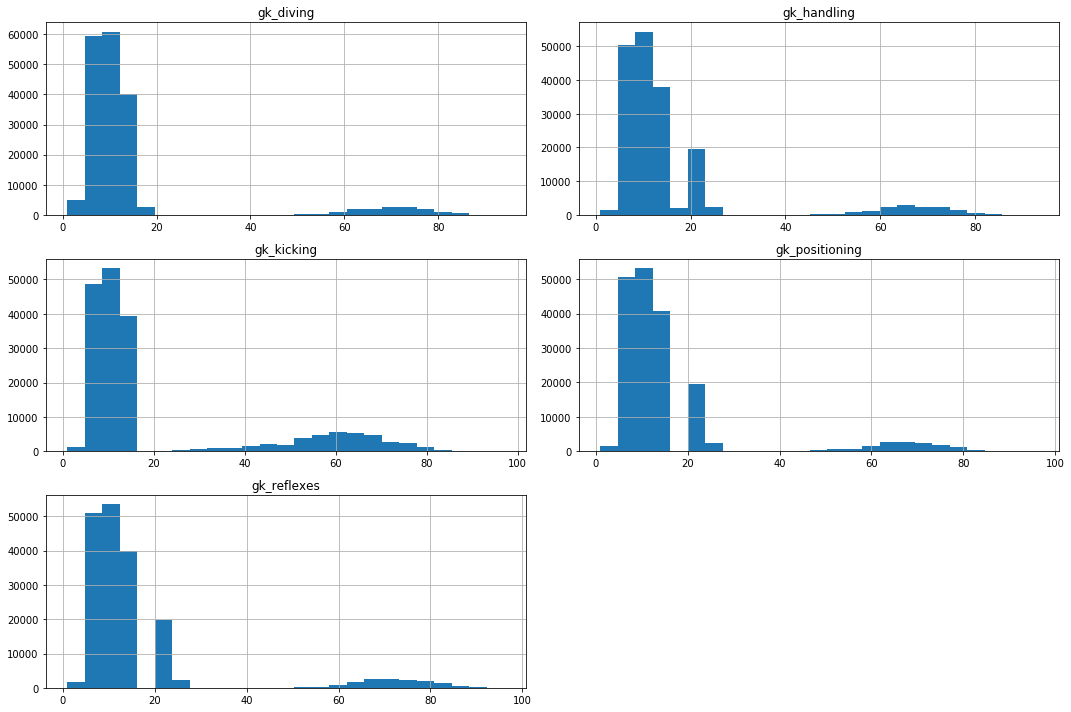

In [20]:
a_df[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']].hist(figsize=(15, 10), bins=25);
plt.tight_layout()

Each one of these variables is skewed to the right, with the bulk of the measurements relating to the field players, but has a cluster of higher values (on the x axis) which correspond to the goalkeepers. It would be useful to actually differentiate between the two categories.
<br>By exploring our *database* we find there is a table (*Match*) with information on 25k+ football matches, which includes the **player position** on the field. We can gather all the players with position 1 (the goalkeepers), and merge this with our *player* dataframe (p_df)

In [21]:
gk_df = pd.read_sql("""SELECT * FROM Match;""", conn)

In [22]:
# looking at the columns in the 'Match' table
gk_df.columns.tolist()

['id',
 'country_id',
 'league_id',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_api_id',
 'away_team_api_id',
 'home_team_goal',
 'away_team_goal',
 'home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player

The columns *home_player_1* and *away_player_1* are the goalkeepers. We can create an array of unique values from both these series.

In [23]:
gk_arr = np.unique(np.concatenate((gk_df.home_player_1, gk_df.away_player_1),0))

In [24]:
gk_arr.shape

(3437,)

There are **3437** goalkeepers in the Match table. We can create a column in our *Player* dataframe to mark if a player is a goalkeeper:

In [25]:
# creating a new column (in the players table) with booleans for if a player is goalkeeper on not
p_df['is_gk'] = np.in1d(p_df.index, gk_arr)

p_df.head(10)

,player_name,birthday,height,weight,is_gk
player_api_id,,,,,
505942,Aaron Appindangoye,1992-02-29,182.88,187,False
155782,Aaron Cresswell,1989-12-15,170.18,146,False
162549,Aaron Doran,1991-05-13,170.18,163,False
30572,Aaron Galindo,1982-05-08,182.88,198,False
23780,Aaron Hughes,1979-11-08,182.88,154,False
27316,Aaron Hunt,1986-09-04,182.88,161,False
564793,Aaron Kuhl,1996-01-30,172.72,146,False
30895,Aaron Lennon,1987-04-16,165.10,139,False
528212,Aaron Lennox,1993-02-19,190.50,181,True


Before merging our players (*p_df*) and attributes (*a_df*) dataframes, we need to average the values in the attributes dataframe, for each player, across the date range.

In [26]:
# we can achieve this using groupby id and mean method:
a_df_grouped = a_df.groupby('player_api_id').mean()
a_df_grouped.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,60.142857,61.142857,50.142857,47.285714,46.285714,56.500000,38.000000,54.142857,50.000000,49.928571,...,55.285714,61.928571,62.928571,63.857143,56.571429,12.428571,12.857143,19.071429,10.357143,10.428571
2752,69.380952,70.380952,36.428571,37.428571,75.333333,54.809524,20.428571,44.857143,30.428571,18.857143,...,52.428571,35.428571,71.095238,70.666667,65.571429,11.095238,6.095238,7.095238,9.095238,15.095238
2768,69.285714,70.571429,42.238095,42.761905,66.666667,64.714286,28.761905,40.238095,51.761905,20.047619,...,57.761905,31.904762,71.666667,70.619048,79.714286,10.761905,15.904762,22.714286,15.142857,12.095238
2770,71.133333,73.533333,61.866667,67.666667,67.800000,72.533333,67.133333,75.066667,79.800000,68.666667,...,71.600000,63.933333,30.200000,37.533333,25.000000,8.666667,15.666667,27.200000,16.333333,17.000000
2790,70.200000,75.800000,70.000000,37.400000,55.200000,68.000000,43.000000,60.800000,67.000000,55.400000,...,60.000000,55.400000,74.600000,74.600000,69.000000,8.000000,17.000000,59.000000,16.600000,17.400000


In [27]:
# check to see how many entries we have in the new grouped dataframe
a_df_grouped.shape

(11060, 35)

Now that we have the same number of rows in each table, corresponding to each unique player, we can **merge** the two dataframes

In [28]:
m_df = p_df.merge(a_df_grouped, left_index=True, right_index=True)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 505942 to 39902
Data columns (total 40 columns):
player_name           11060 non-null object
birthday              11060 non-null datetime64[ns]
height                11060 non-null float64
weight                11060 non-null int64
is_gk                 11060 non-null bool
overall_rating        11060 non-null float64
potential             11060 non-null float64
crossing              11060 non-null float64
finishing             11060 non-null float64
heading_accuracy      11060 non-null float64
short_passing         11060 non-null float64
volleys               10582 non-null float64
dribbling             11060 non-null float64
curve                 10582 non-null float64
free_kick_accuracy    11060 non-null float64
long_passing          11060 non-null float64
ball_control          11060 non-null float64
acceleration          11060 non-null float64
sprint_speed          11060 non-null float64
agility               10582 no

After joining the two dataframes we notice there are still missing values. It means these attributes never had any values for some of the players.
<br>We now have three choices: 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-to discard the players with missing values by dropping the rows (there are only 478 (11060 - 10582) out of 11060);
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-to disregard the columns with missing values, thus limiting our analysis;
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-or, to fill the missing values with the average, but we'll have to account for the different types of players (field vs goalkeepers)
<br>None of these solutions is convenient, but going for the third option seems to preserve the most data, so we'll do that.
<br>For each of the two player categories (field players and goalkeepers) we want to fill the NaNs with the average on the missing value columns.
<br>Since we expect certain attributes to be more relevant to the field players, while others are specific to the goalkeepers, we might as well **split** the dataframe in two categories.

In [29]:
# first we create the categories: field players and goalkeepers
fp = m_df.is_gk == False
gk = m_df.is_gk == True

In [30]:
# create the field players dataframe and fill the NaN values with the mean
fp_df = m_df[fp]
fp_df = fp_df.fillna(fp_df.mean())

In [31]:
# drop goalkeeper specific columns from the field players dataframe
fp_df.drop(fp_df.columns[-5:], axis = 1, inplace=True)

# drop 'is_gk' column since no longer relevant
fp_df.drop('is_gk', axis=1, inplace=True)

In [32]:
# filter by goalkeepers and fill NaNs with the mean
gk_df = m_df[gk]
gk_df = gk_df.fillna(gk_df.mean())

In [33]:
# remove field player specific columns from goalkeepers dataframe
gk_df.drop(gk_df.columns[:-5], axis = 1, inplace=True)

In [34]:
# checking for null values again in each set
fp_df.info()
gk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10081 entries, 505942 to 39902
Data columns (total 34 columns):
player_name           10081 non-null object
birthday              10081 non-null datetime64[ns]
height                10081 non-null float64
weight                10081 non-null int64
overall_rating        10081 non-null float64
potential             10081 non-null float64
crossing              10081 non-null float64
finishing             10081 non-null float64
heading_accuracy      10081 non-null float64
short_passing         10081 non-null float64
volleys               10081 non-null float64
dribbling             10081 non-null float64
curve                 10081 non-null float64
free_kick_accuracy    10081 non-null float64
long_passing          10081 non-null float64
ball_control          10081 non-null float64
acceleration          10081 non-null float64
sprint_speed          10081 non-null float64
agility               10081 non-null float64
reactions             10081

<a id='eda'></a>
## Exploratory Data Analysis

This chapter will address the questions mentioned in the introduction by means of basic statistical exploration. The focus will be on **field players**, as there are more variables concerning this category.

<a id="q1"></a>
### What are the top characteristics of highly rated players?
For this question we need to:
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- define what 'highly rated' means for players
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- draw the average of their attributes
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- compare the selected group to the rest of the sample to see which attributes stand out (have the strongest deviation vs the mean)

If we were to gauge players' performance by looking at just one variable, the *overall_rating* seems the most likely pick. <br>Looking at the **descriptives** for all the attributes:

In [35]:
fp_df.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
height,181.228912,6.122219,157.480000,177.800000,180.340000,185.420000,203.200000
weight,166.872532,14.283868,117.000000,157.000000,165.000000,176.000000,225.000000
overall_rating,66.837201,6.205792,43.000000,62.869565,66.750000,70.931034,92.192308
potential,72.161195,5.766399,51.000000,68.000000,72.100000,76.000000,95.230769
crossing,56.048498,12.870822,7.600000,47.523810,57.875000,65.400000,89.357143
finishing,50.665878,16.332731,10.000000,37.033333,52.944444,64.000000,92.230769
heading_accuracy,59.577579,11.280598,13.153846,52.200000,60.111111,67.500000,93.111111
short_passing,63.443288,9.276735,21.000000,58.000000,64.000000,69.678571,95.181818
volleys,49.939601,14.987345,9.400000,38.777778,50.538462,61.157895,90.789474
dribbling,60.473666,12.706204,14.000000,53.516129,62.529412,69.450000,96.461538


We notice the *overall_rating* ranges between 43 and 92, with the majority of players below the 70 level.
<br>If we define a **threshold** for the *overall_rating* at 80, we get: 

In [36]:
top = fp_df.overall_rating > 80  #  defining the top players threshold
fp_df[top].shape[0]  # aplying the mask to the players dataframe

190

190 players constituting our top rating sample.
<br>We can compare the descriptive statistics of this subgroup against the general values:

In [37]:
(
((fp_df[top].describe() - fp_df.describe())  # subtracting overall values from the top rated
    /fp_df.describe()).T  # deviding by the overall values to get the variance in %s, and transpose
    .sort_values('mean', ascending=False)  # sorting by the mean to get the most significant variation at the top
    .drop('count', axis=1)  # drop the 'count' column
)

,mean,std,min,25%,50%,75%,max
volleys,0.391525,0.052829,1.446809,0.524109,0.505187,0.331894,0.000000
free_kick_accuracy,0.346887,0.074877,2.342857,0.463219,0.440017,0.312144,0.000000
finishing,0.338379,0.114515,1.033333,0.551821,0.386878,0.294046,0.000000
penalties,0.320149,-0.170276,3.714706,0.461989,0.348584,0.254813,-0.026465
curve,0.319981,0.066951,0.770833,0.407151,0.428371,0.281595,0.000000
positioning,0.313538,-0.099712,3.121173,0.424236,0.341772,0.249358,0.000000
long_shots,0.311365,0.043001,1.475000,0.522185,0.337287,0.244430,0.000000
vision,0.295809,-0.070816,2.344482,0.304890,0.344654,0.261880,0.000000
reactions,0.252729,-0.465146,1.085714,0.323592,0.243328,0.189565,0.000000
dribbling,0.246082,0.005777,1.269231,0.325429,0.285860,0.206075,0.000000


We can see that the top rated players tend to outmatch the average players in almost every aspect, but they are particularly superior in ***volleys***, where they outperform by almost ***40%***. ***Free_kick_accuracy***, ***finishing*** and ***penalties*** follow with ***35%***, ***34%*** and ***32%*** improvements respectively.
<br>Interestingly, the negative values in the *max* column signify that the best players in those attributes are actually not part of our top selection (meaning they have an *overall_rating* < 80).
<br>To visually confirm our finding we can look at the following plot comparing the means of the two groups for a selection of attributes: 

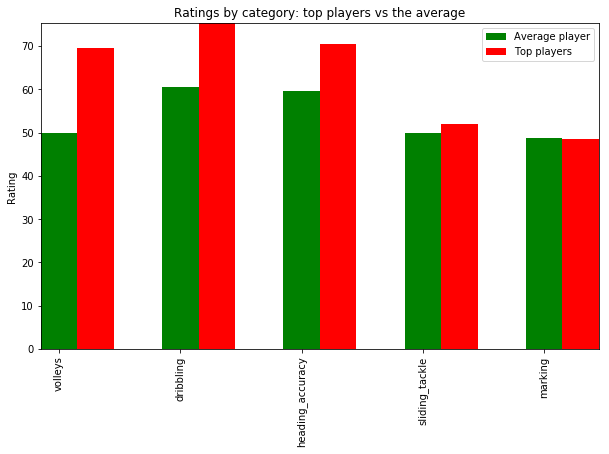

In [73]:
# selecting attributes to visualize
selection = ['volleys', 'dribbling', 'heading_accuracy', 'sliding_tackle', 'marking']

# defining the first series to plot
y1 = fp_df[selection].mean()
x1 = np.arange(len(y1))

# # defining the second series
y2 = fp_df[top][selection].mean()

# build the plot
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x1, y1, width = 0.3, color='g', label = 'Average player')
ax.bar(x1+0.3, y2, width = 0.3, color ='r', label = 'Top players')
ax.set_ylabel('Rating')
ax.set_title('Ratings by category: top players vs the average')
ax.set_xticks(x1)
ax.set_xticklabels(y1.index, rotation=90)
ax.autoscale(tight=True)
ax.legend();

It becomes more visible which are the areas in which the top performing players excel the most, and where they are not much different from the average. Actually in ***marking***, they tend to perform slightly worse then the average players.

<a id="q2"></a>
### In what way does players' BMI (Body Mass Index) influence their performance?
<br>The BMI is a known tool that measures the mass of the body in relation to height and weight.
<br>For the scope of this question we'll calculate the BMI variable, and try to visually determine which of the attributes vary along with it. We'll use [this formula from NHS](https://www.nhs.uk/chq/Pages/how-can-i-work-out-my-bmi.aspx?CategoryID=51&SubCategoryID=165) to calculate the BMI:
\begin{equation*}
\textrm{BMI} = \frac{\Bigl(\frac{\textrm{weight (kg)}}{\textrm{height (m)}}\Bigr)}{\textrm{height (m)}}
\end{equation*}

In [39]:
# bofore applying the formula we need to convert weight from pounds to kilograms
fp_df.weight = fp_df.weight * 0.453592

# and the height from centimeters to meters
fp_df.height = fp_df.height / 100

# create the 'bmi' metric
fp_df['bmi'] = (fp_df.weight / fp_df.height) / fp_df.height

In [40]:
# checking how calculations look
fp_df[['height','weight', 'bmi']].head()

,height,weight,bmi
player_api_id,,,
505942,1.8288,84.821704,25.361478
155782,1.7018,66.224432,22.866579
162549,1.7018,73.935496,25.529126
30572,1.8288,89.811216,26.853330
23780,1.8288,69.853168,20.885923


Now we can plot a scatter plot of BMI against selected dependent variables to see if we can spot any correlation.

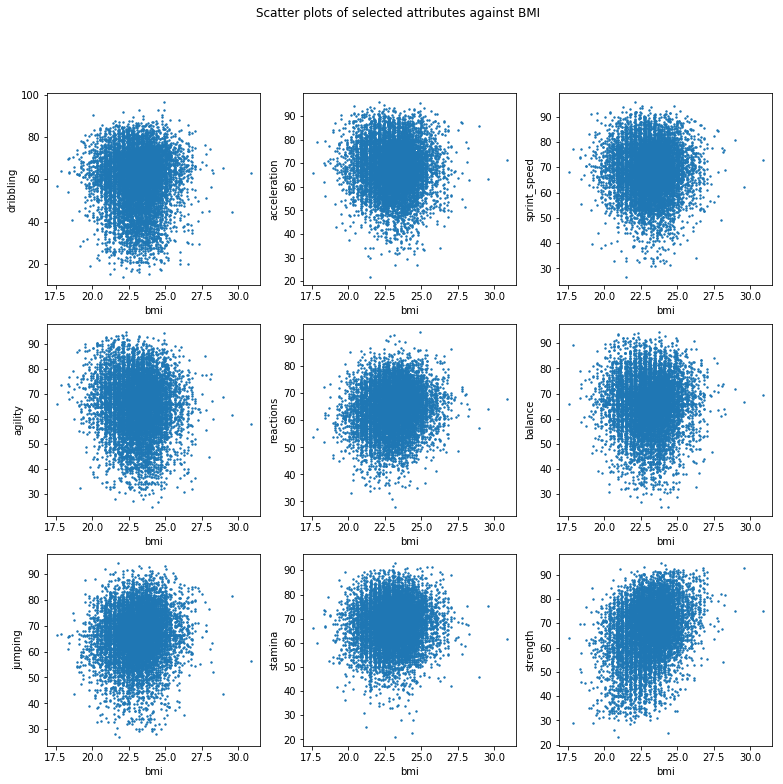

In [41]:
# selecting variables which might be influence by BMI
selected_vars = ['dribbling', 'acceleration', 'sprint_speed', 'agility', 
                 'reactions', 'balance', 'jumping', 'stamina', 'strength']

# initiate the plot
fig, ax = plt.subplots(figsize=(13,12))

# using a function to avoid repetition
def draw_scatter_plots(n, ylabel):
    plt.subplot(3,3,n)
    plt.scatter(fp_df.bmi, fp_df[ylabel], s=2)
    plt.ylabel(ylabel)
    plt.xlabel('bmi')

#  drawing the plots
for n, label in enumerate(selected_vars, 1):
    draw_scatter_plots(n, label)

#  prettify the plot
plt.suptitle('Scatter plots of selected attributes against BMI');

None of the selected attributes seems to be particularly influenced BMI, as there is no visible strong trend in any of the scatter plots. However, if we are to pick a winner here, the *strength* area seems to show a slight movement, where values tend to generally increase as the BMI increases. This is something to be expected.

<a id="q3"></a>
### Which performance attributes improve with age, and which ones decline?

To investigate this question we can look at the averages of selected performance attributes accross age groups. We plan to plot these in one line graph and check the trends.

In [42]:
# First we need to calculate the age. We'll subtract the birthday from the date of the last observation, rounding to years.
last = a_df.date.max()
fp_df['age'] = (last.year - fp_df.birthday.dt.year)

In [44]:
# Next, we group by age and draw the means for the relevant attributes, saving as a new dataframe.
age_means = fp_df.iloc[:,4:].groupby('age').mean()
age_means.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,bmi
age,,,,,,,,,,,,,,,,,,,,,
17,64.333333,84.000000,39.000000,66.000000,64.000000,53.000000,50.000000,62.000000,46.000000,34.000000,...,57.000000,30.000000,16.000000,60.000000,53.000000,78.000000,20.000000,17.000000,23.000000,19.122826
18,56.629998,74.208069,42.070346,40.522398,49.813023,52.231142,38.044841,54.126808,41.521356,37.285245,...,38.554343,50.574125,42.499639,45.439643,45.696167,47.792190,41.170094,46.631521,45.656079,22.351153
19,60.131612,74.550624,48.192560,46.865588,51.304404,57.892245,43.826404,58.976690,47.019570,41.722461,...,45.411133,49.251194,41.028813,50.573823,51.453265,50.977601,39.809134,44.093973,43.611863,22.181839
20,60.443615,73.200656,48.215889,47.943741,51.358225,58.545207,44.476341,59.388320,47.352961,41.370142,...,46.125720,49.477706,39.813588,50.396539,52.063697,51.003346,39.674367,43.439154,42.683165,22.286391
21,61.858643,73.166445,49.110885,46.256013,52.973197,59.468877,44.436710,59.048863,47.564539,42.439274,...,46.731879,53.494128,44.981853,50.667663,51.432102,49.993210,44.160297,48.002930,46.711685,22.460909


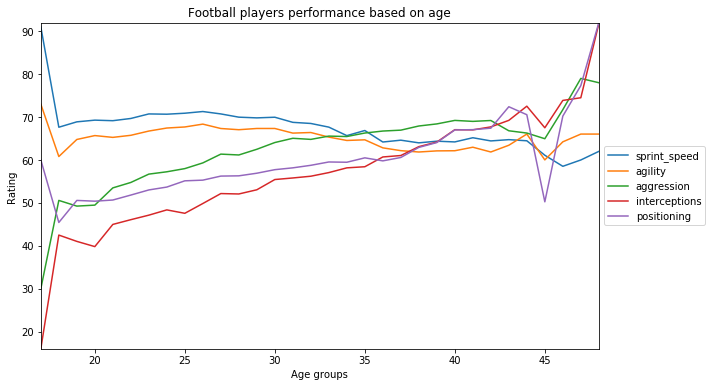

In [51]:
# selecting variables to investigate
selected_vars1 = ['sprint_speed', 'agility', 'aggression', 'interceptions','positioning']

# initiate the plot
fig, ax = plt.subplots(figsize=(10,6))

# using a function to draw
def draw_line_plot(y):
    plt.plot(age_means.index, age_means[y], label=y)

#  drawing the plot
[draw_line_plot(column) for column in selected_vars1]

# prettify the plot
plt.xlabel('Age groups')
plt.ylabel('Rating')
plt.title('Football players performance based on age')
plt.autoscale(tight=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

We notice there is a lot of 'oscillation' on both extremes of the age groups. The youngest and the oldest players tend to either have very high or very low values in some areas. This probably has to do with fewer players in those groups. We can see this from the age distribution:

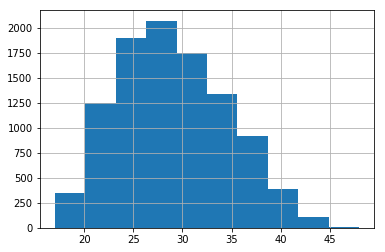

In [52]:
fp_df.age.hist();

To get a clearer picture we can limit the view to just players between 20 and 40 years old.

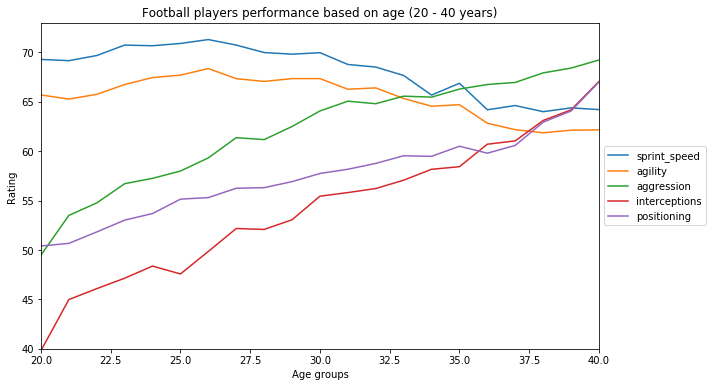

In [53]:
# redoing the previous steps to get a better view
fig, ax = plt.subplots(figsize=(10,6))
[draw_line_plot(column) for column in selected_vars1]
plt.xlim(20, 40)
plt.ylim(40,73)
plt.xlabel('Age groups')
plt.ylabel('Rating')
plt.title('Football players performance based on age (20 - 40 years)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

This time we can see more clearly that although the overall tendency is for the players' attributes to improve with age, some values are actually declining (*sprint_speed* and *agility* being two examples).

<a id="q4"></a>
### Are higher players really better at heading / jumping / vision?
One would think that higher players have an advantage over the rest in specific areas, like heading and jumping.
Out of all attributes in the dataset, three in particular seem to relate to this question: *heading_accuracy*, *jumping* and *vision*.
<br>A 'high' player could means different things from in different sports. In order to establish what a 'high' player means in soccer, we look at the distribution of heights:

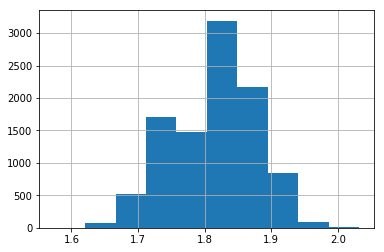

In [75]:
fp_df.height.hist();

It would be reasonable to consider that players over 1.90m are part of the high players category.

In [76]:
# define the mask
high = fp_df.height > 1.90

# count haw many are high
fp_df[high].shape[0]


940

There are 940 players matching this criteria. To investigate how they perform in the three selected variables, we use the same plotting style as in the first question about the top characteristics of players.

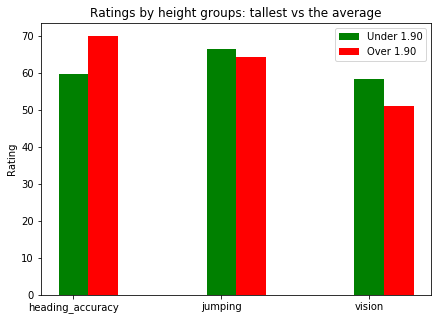

In [79]:
# defining the first series to plot
y1 = fp_df.loc[:,['heading_accuracy', 'jumping', 'vision']].mean()
x1 = np.arange(len(y1))

# # defining the second series
y2 = fp_df[high].loc[:,['heading_accuracy', 'jumping', 'vision']].mean()

# # build the plot
fig, ax = plt.subplots(figsize=(7,5))
width = 0.2
ax.bar(x1, y1, width, color='g', label = 'Under 1.90')
ax.bar(x1+0.2, y2, width, color ='r', label = 'Over 1.90')
ax.set_ylabel('Rating')
ax.set_title('Ratings by height groups: tallest vs the average')
ax.set_xticks(x1)
ax.set_xticklabels(y1.index, )
ax.legend();

Interestingly, players who are taller don't seem to perform better in neither *jumping* nor *vision*, but their *heading accuracy* is superior to that of the average. 

<a id="q5"></a>
### Can zodiac sign influence a player's talents?
This last question may seem rather obscure and does not bear much significance from a scientific point of view. Nevertheless, it may be interesting to see if certain astrological characteristics would be reflected in how soccer players talents are distributed.

With a little manipulation and using the information on this [site](http://astrostyle.com/zodiac-sign-dates/), we get the dates corresponding to the 12 astological signs in the following format:

In [81]:
# keys represent a touple of (month_start, day_start, month_end, day_end)
signs = {
    (3, 21, 4, 19): 'aries',
    (4, 20, 5, 20): 'taurus',
    (5, 21, 6, 20): 'gemini',
    (6, 21, 7, 22): 'cancer',
    (7, 23, 8, 22): 'leo',
    (8, 23, 9, 22): 'virgo',
    (9, 22, 10, 22): 'libra',
    (10, 23, 11, 21): 'scorpio',
    (11, 22, 12, 21): 'sagittarius',
    (12, 22, 1, 19): 'capricorn',
    (1, 20, 2, 18): 'aquarius',
    (2, 19, 3, 20): 'pisces'
}

In [82]:
# defining a formula to get the zodiac sign from a timestamp:
def get_sign(ts):
    return [v for k, v in signs.items() if (ts.month == k[0] and ts.day >= k[1]) or (ts.month == k[2] and ts.day <= k[3])][0]

# create a column with zodiac sign for each player
fp_df['sign'] = fp_df.birthday.apply(get_sign)

# select variables to investigate
selected_vars3 = fp_df.drop(['weight', 'height', 'bmi', 'age'], axis=1).columns

# group by zodiac sign and get the means
fp_df.groupby('sign')[selected_vars1].mean()

,sprint_speed,agility,aggression,interceptions,positioning
sign,,,,,
aquarius,68.375613,65.539580,61.624528,54.257924,55.754643
aries,68.953895,65.811864,61.937088,53.514928,56.854764
cancer,68.957907,65.911898,61.537461,53.553157,56.973934
capricorn,69.100586,66.449093,61.107485,53.195959,56.619960
gemini,68.896269,66.340557,61.810973,52.567724,57.876180
leo,68.920517,66.047617,62.452721,52.976957,57.775340
libra,68.222042,65.485408,62.612288,54.177917,56.886690
pisces,68.637847,66.233811,61.315103,52.532079,56.654972
sagittarius,69.610868,66.279526,62.059626,53.089995,58.169913


In order to observe how the means for each sign differ from the average in each attribute, we subtract the means of the ungrouped data (which is a 1D array) from the table above (a 2D array), and convert everything to percentages (divide by the ungrouped means). This is the table obtained:

In [83]:
variations = (fp_df.groupby('sign')[selected_vars3].mean() - fp_df[selected_vars3].mean())/fp_df[selected_vars3].mean() * 100
variations

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle
sign,,,,,,,,,,,,,,,,,,,,,
aquarius,-0.495414,0.076643,-0.773967,-3.710566,-0.915753,-0.125486,-2.893866,-1.454305,-0.571110,-1.573984,...,-0.431088,-2.035831,-0.107924,1.710725,-2.218885,-1.467533,-1.759250,3.005988,3.386506,3.511044
aries,-0.382352,-0.202626,-0.249782,-0.900946,0.294525,-0.136010,-0.297510,-0.338759,-0.754726,-0.896073,...,-0.173125,-0.676814,0.398729,0.317921,-0.289521,-0.524523,-0.471175,-0.267018,-0.557920,-0.481429
cancer,0.147750,0.140928,0.662360,0.184448,0.008140,0.454568,-0.703604,-0.261453,-0.205321,-0.109456,...,-0.366576,0.207341,-0.249057,0.389584,-0.080522,0.084294,-0.391694,0.511268,0.597879,1.297656
capricorn,-0.465290,-0.250630,-0.945939,0.086666,-0.632123,-0.518012,-0.040721,-0.127518,-0.812489,-0.819869,...,-0.555413,-0.634727,-0.946041,-0.280013,-0.701314,-0.246259,-0.704306,-0.950135,-0.589134,-0.794011
gemini,0.756659,0.218962,0.857344,2.857914,0.481718,0.614332,1.564613,1.746331,1.564383,0.462970,...,0.567942,1.265760,0.194299,-1.457687,1.501814,0.291861,1.283800,-2.557226,-2.094814,-1.971326
leo,0.657757,0.394556,0.311635,1.395853,1.934140,0.222644,0.973190,0.002115,0.491257,0.771984,...,1.093090,0.542514,1.234560,-0.690548,1.324964,-0.191141,1.630258,-0.152129,-0.216689,-0.273371
libra,-0.404314,-0.411288,-0.211932,-2.162248,0.392548,-0.969645,-0.086438,-1.042360,-0.385925,-0.232961,...,1.005972,-1.059518,1.493214,1.560745,-0.233528,-0.444325,-0.354534,1.925669,1.317437,1.217012
pisces,-0.517685,0.000813,-0.786119,-0.428222,-0.608985,0.043151,-0.889340,-0.061892,-0.052906,-0.124249,...,-0.841167,-0.169796,-0.609496,-1.524508,-0.639910,0.136051,-1.341338,-0.290817,-0.631730,-0.482873
sagittarius,1.078546,0.367617,1.821177,2.622368,1.458991,0.082715,2.828432,1.211261,0.422816,0.856346,...,1.336237,1.593880,0.597361,-0.478650,2.016956,0.909989,1.715045,-0.513276,-0.621715,-0.244229


Finally, to visualize all this data we use a heatmap in seaborn:

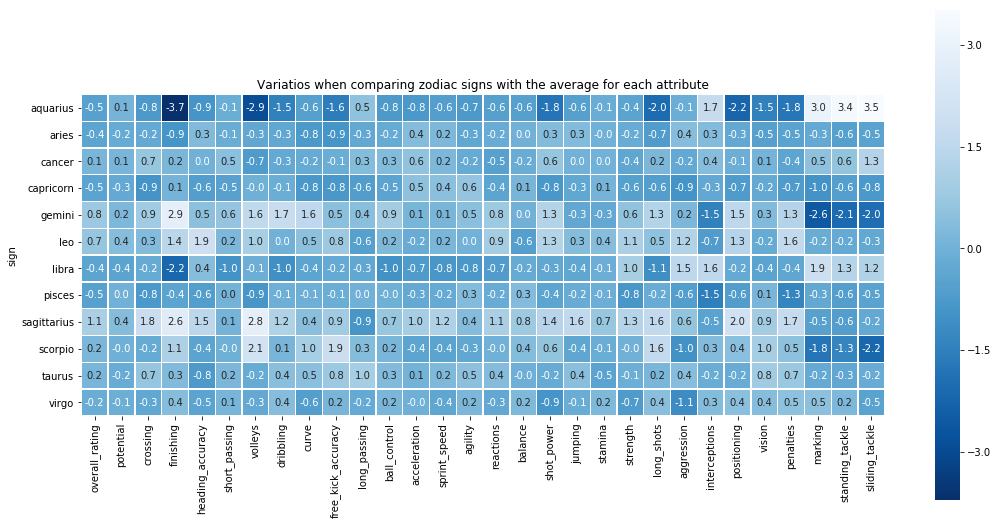

In [84]:
plt.figure(figsize=(18,9))
plt.title('Variatios when comparing zodiac signs with the average for each attribute')
sns.heatmap(variations, annot=True, fmt='.1f', linewidths=0.3, square=True, cmap='Blues_r');

The differences in performance do not appear to be significant, ranging between -3.5% and +3.7% vs the mean. 
<br>One can remark though, that while 'gemini' are almost 3% better at *finishing*, 'aquarius' underperform by 3.7% in the same category when compared to the average. But they also seem to be the best of all the signs at *sliding_takle*, by a margin of 3.5% vs the mean.

To see if any of these findings have any statistical relevance or could be just random results, we can create another set of 'control groups' with the same number of categories, and perform the same analysis.

In [85]:
# create a random group label column
fp_df['random_group'] = np.random.randint(1, 13, fp_df.shape[0])

# check the result
fp_df.random_group.value_counts()

3     887
12    853
8     852
7     849
10    846
1     841
11    840
6     836
2     835
4     821
5     817
9     804
Name: random_group, dtype: int64

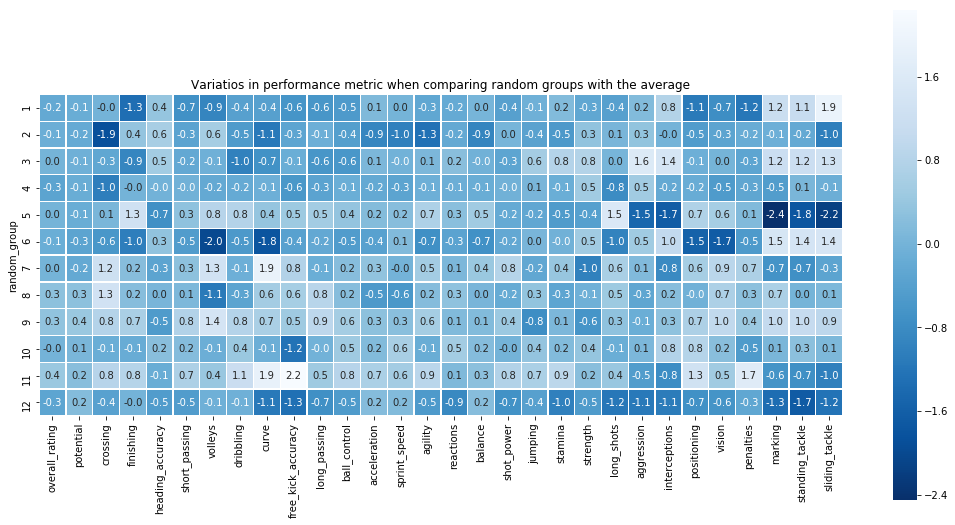

In [86]:
# redo previous steps to plot the heatmap based on the new random groups
variations1 = ((fp_df.groupby('random_group')[selected_vars3].mean()
              - fp_df[selected_vars3].mean())
              / fp_df[selected_vars3].mean() * 100)
plt.figure(figsize=(18,9))
plt.title('Variatios in performance metric when comparing random groups with the average')
sns.heatmap(variations1, annot=True, fmt='.1f', linewidths=0.3, square=True, cmap='Blues_r');

The resulting heatmap shows almost the same % variations, albeit within a smaller range (-2.2% to +2.8%).
<br>This leads to the conclusion that, when comparing performance attributes, grouping football players by their zodiac sign returns *almost* the same results as when grouping them randomly.

<a id='conclusions'></a>
## Conclusions

Based on this preliminary exploration the results of our research questions reveal the following:
- 'Top players' as identified by the *overall_rating* tend to perform better in almost every aspect, with the exception of *marking*, where their performance is sub-average. This can be justified by the fact that the *overall_rating* metric itself may be some kind of average of the other attributes.
<br>**Limitations**: If the individual metrics are part of the *overall_rating* calculation, their values could already be correlated, and our result is therefore not surprising. The negative values obtained in the max column after calculating the variance between top and average players, signify that the best players in those attributes were actually not part of our top selection. Therefore the selection criteria is no infallible and could be improved.


- BMI does not seem to influence the performance of any particular attribute, with the exception of *strength*, where a slight tendency is suggested by the scatter plot.
<br>**Limitations**: The trend visible in the plot seems to be weak, therefore further statistical tests would be required to conclude a real correlation exists.


- The age analysis reveals that most of the players' performance mertrics generally improve constantly until around the age of 35, after which some decline and some increase even more. In 'tactical' areas like *interception* and *positioning*, experience tends to cummulate over time, therefore these metrics showed consistent growth with age. Also an increase in *aggression* was observable, probabily explained by a decrease in tollerance towards non-fair play? On the other hand, physical characteristics like *speed* and *agility* showed a visible decline after the age of 35, which is something to be expected in football.
<br>**Limitations**: Very young or very 'old' players are an exception in football, se we decided to exclude these numbers as the observations were limited. Result are again an approximation, as the date range was truncated to smoothen the trends.


- When analyzing the *heights* we found that tall players don't necessarily perform better in *jumping* or *vision* (which may seem counterintuitive), but their *heading_accuracy* was still marginally better than the average.
<br>**Limitations**: The threshold in defining 'tallness' is arbitrary and could be debatable. Also, the *vision* attribute was selected on the assumption that players with big height might have a better view over the pitch, but that is also debatable.


- Finally, zodiac signs don't seem to have any influence over how players perform in any of the areas. The result that we found, which may indicate that some zodiac signs perform better or worse than others in some respects, is only marginally more proeminent than that of a random grouping.
<br>**Limitations**: There could be many other explenations for why players in the 'aquarius' category underperform in *finishing*, or why 'sagittarius' tend to be almost 3% better at *volleys* when compared to the average (a few very 'good' or very 'bad' players might 'accidentally' happen to be part of that group, which does not make statistically relevant). Therefore, further investigation would be required if we want to connect in any way football to astrology.